# Imports

In [225]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# Download BTC-USD historical data

In [226]:
btc = yf.download('BTC-USD', start='2013-02-08', end='2025-10-03', interval='1d')
btc.reset_index(inplace=True)
btc['index'] = range(390198, 390198 + len(btc))
btc['Name'] = 'BTCUSDT'

btc = btc.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

btc = btc[['index', 'date', 'open', 'high', 'low', 'close', 'volume', 'Name']]

C:\Users\mhsh\AppData\Local\Temp\ipykernel_18292\3135887192.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2013-02-08', end='2025-10-03', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [227]:
data = btc

## Add RSI and Change

In [228]:
data['change'] = data['close'].diff()
data['change'] = data['change'].fillna(0)
def compute_rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(com=period-1, adjust=False).mean()
    ma_down = down.ewm(com=period-1, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-12)
    rsi = 100 - (100 / (1 + rs))
    return rsi
data["rsi_14"] = compute_rsi(data["close"], period=14)
data["rsi_14"] =data["rsi_14"].fillna(0)

## normalize

In [229]:


scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[['close', 'rsi_14','change']])




## Create sequences of data for LSTM

In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])  # Predict next close
    return np.array(X), np.array(y)

window_size = 60  # e.g., use past 60 days
X, y = create_sequences(scaled, window_size)

print("X shape:", X.shape)  
print("y shape:", y.shape) 
data.head()



X shape: (3974, 60, 3)
y shape: (3974,)


Price,index,date,open,high,low,close,volume,Name,change,rsi_14
Ticker,,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,
0,390198,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,BTCUSDT,0.000000,0.000000
1,390199,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,BTCUSDT,-32.894012,0.000000
2,390200,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,BTCUSDT,-29.644012,0.000000
3,390201,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,BTCUSDT,14.108002,3.215775
4,390202,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,BTCUSDT,-10.082977,3.138104


## Create Model

In [231]:


model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(window_size, 3)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Predict next close price

])

model.compile(optimizer='adam', loss='mse')



c:\Users\mhsh\Documents\lstm\venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train

In [232]:
model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0042
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0012
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 7.9286e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 8.9787e-04
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 5.4679e-04
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 6.6374e-04
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 5.4092e-04
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 5.6125e-04
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 4.4880e-04
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 4.8515e-04
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 5.2873e-04
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 4.6326e-04
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 4.4226e-04
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 4.488

## Predict

In [233]:
y_pred = model.predict(X)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


## Convert data to readable version

In [234]:
y_true = scaler.inverse_transform(
    np.hstack([y.reshape(-1, 1), np.zeros((len(y), 2))])
)[:, 0]

y_pred_inv = scaler.inverse_transform(
    np.hstack([y_pred, np.zeros((len(y_pred), 2))])
)[:, 0]

rmse = np.sqrt(mean_squared_error(y_true, y_pred_inv))
mae = mean_absolute_error(y_true, y_pred_inv)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 2350.39, MAE: 1184.13


## Plots

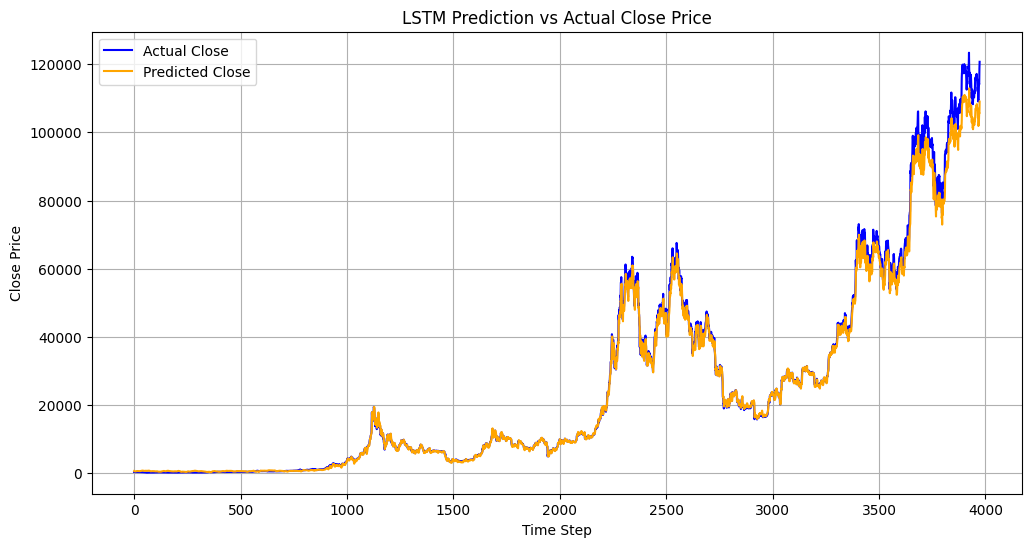

In [235]:
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual Close', color='blue')
plt.plot(y_pred_inv, label='Predicted Close', color='orange')
plt.title('LSTM Prediction vs Actual Close Price')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


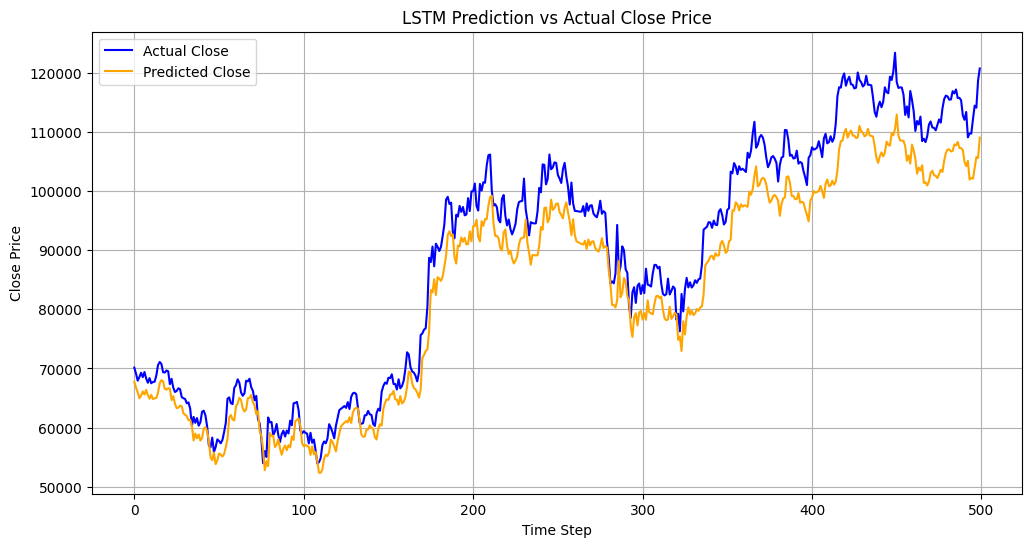

In [239]:
plt.figure(figsize=(12,6))
plt.plot(y_true[-500:], label='Actual Close', color='blue')
plt.plot(y_pred_inv[-500:], label='Predicted Close', color='orange')
plt.title('LSTM Prediction vs Actual Close Price')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()